# Model Training: Volatility and Risk Level Prediction

This notebook trains models to predict **future volatility** and **risk levels** of Vietnamese FDI stocks using:
- **Enhanced features**: 8 technical + 9 macroeconomic + 17 fundamental indicators
- **Advanced risk metrics**: VaR, CVaR, Sharpe ratio, maximum drawdown
- **Multiple architectures**: Random Forest, LSTM, GRU, Hybrid GNN-LSTM
- **Multi-task learning**: Simultaneous volatility regression + risk classification

## Objectives
1. Define volatility-based risk labels (Low/Medium/High)
2. Train baseline models for comparison
3. Train hybrid GNN-LSTM model with graph structure
4. Evaluate performance on multiple metrics
5. Analyze feature importance and predictions

## 1. Import Required Libraries

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')

# Standard libraries
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# PyTorch and PyTorch Geometric
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader as GeoDataLoader

# Scikit-learn
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, confusion_matrix, accuracy_score
)

# Import custom modules
from datasets.EnhancedDataset import EnhancedVolatilityDataset
from models.hybrid_gnn_lstm import MultiTaskHybridGNN
from risk_metrics import calculate_risk_labels

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

✓ All libraries imported successfully
PyTorch version: 2.9.1
Device: cpu


## 2. Load and Prepare the Dataset

Load the enhanced dataset with all features (technical, macro, fundamental).

In [2]:
# Paths
data_dir = Path('../data')
processed_dir = data_dir / 'processed'
features_dir = data_dir / 'features'

# Load enriched data
enriched_df = pd.read_csv(
    processed_dir / 'values_enriched.csv',
    index_col=['Symbol', 'Date'],
    parse_dates=['Date']
)

# Load fundamentals
fundamentals_df = pd.read_csv(features_dir / 'fundamentals.csv', index_col='ticker')

# Load macro data
macro_df = pd.read_csv(
    features_dir / 'macro_data.csv',
    index_col='Date',
    parse_dates=['Date']
)

print(f"Enriched data shape: {enriched_df.shape}")
print(f"Fundamentals shape: {fundamentals_df.shape}")
print(f"Macro data shape: {macro_df.shape}")
print(f"\nEnriched features: {enriched_df.columns.tolist()}")
print(f"\nDate range: {enriched_df.index.get_level_values('Date').min()} to {enriched_df.index.get_level_values('Date').max()}")
print(f"Number of stocks: {enriched_df.index.get_level_values('Symbol').nunique()}")

enriched_df.head(10)

Enriched data shape: (75754, 19)
Fundamentals shape: (98, 18)
Macro data shape: (782, 9)

Enriched features: ['Unnamed: 0', 'Close', 'NormClose', 'DailyLogReturn', 'ALR1W', 'ALR2W', 'ALR1M', 'ALR2M', 'RSI', 'MACD', 'VN_Index', 'VN_Index_Return', 'VN_Index_Volatility', 'USD_VND', 'USD_VND_Change', 'Policy_Rate', 'Interbank_Rate', 'CPI', 'Inflation_YoY']

Date range: 2022-01-03 00:00:00 to 2024-12-31 00:00:00
Number of stocks: 98


Unnamed: 0       Close  NormClose  DailyLogReturn  \
Symbol Date                                                            
VNM    2022-01-03           0  170.194071   1.505269       -0.022974   
       2022-01-04           1  166.328523   1.361113       -0.022974   
       2022-01-05           2  167.295573   1.397177        0.005797   
       2022-01-06           3  175.076875   1.687360        0.045463   
       2022-01-07           4  177.578807   1.780663        0.014189   
       2022-01-10           5  184.111321   2.024276        0.036126   
       2022-01-11           6  181.170089   1.914590       -0.016104   
       2022-01-12           7  180.690187   1.896694       -0.002652   
       2022-01-13           8  181.104313   1.912137        0.002289   
       2022-01-14           9  182.781013   1.974666        0.009216   

                      ALR1W     ALR2W     ALR1M     ALR2M        RSI  \
Symbol Date                                                            
VNM    2022-01-03  3.961500  1.570067  1.509347  0.376326  54.303169   
       2022-01-04  3.961500  1.570067  1.509347  0.376326  54.303169   
       2022-01-05  3.961500  1.570067  1.509347  0.376326  54.303169   
       2022-01-06  3.961500  1.570067  1.509347  0.376326  54.303169   
       2022-01-07  3.961500  1.570067  1.509347  0.376326  54.303169   
       2022-01-10  3.961500  1.570067  1.509347  0.376326  54.303169   
       2022-01-11  4.307760  1.570067  1.509347  0.376326  54.303169   
       2022-01-12  3.881896  1.570067  1.509347  0.376326  54.303169   
       2022-01-13  1.705940  1.570067  1.509347  0.376326  54.303169   
       2022-01-14  1.455264  1.570067  1.509347  0.376326  54.303169   

                       MACD     VN_Index  VN_Index_Return  \
Symbol Date                                                 
VNM    2022-01-03  0.000000  1200.000000         0.007751   
       2022-01-04 -0.086727  1209.300855         0.007751   
       2022-01-05 -0.080519  1207.155598        -0.001774   
       2022-01-06  0.205218  1219.245657         0.010015   
       2022-01-07  0.455721  1247.465644         0.023145   
       2022-01-10  0.877075  1243.458409        -0.003212   
       2022-01-11  0.998944  1239.464353        -0.003212   
       2022-01-12  1.041775  1269.196863         0.023988   
       2022-01-13  1.076130  1284.188008         0.011812   
       2022-01-14  1.171209  1275.529864        -0.006742   

                   VN_Index_Volatility       USD_VND  USD_VND_Change  \
Symbol Date                                                            
VNM    2022-01-03               0.2286  23500.000000        0.000565   
       2022-01-04               0.2286  23513.272796        0.000565   
       2022-01-05               0.2286  23471.725717       -0.001767   
       2022-01-06               0.2286  23455.131061       -0.000707   
       2022-01-07               0.2286  23431.210786       -0.001020   
       2022-01-10               0.2286  23472.593742        0.001766   
       2022-01-11               0.2286  23454.378540       -0.000776   
       2022-01-12               0.2286  23478.920667        0.001046   
       2022-01-13               0.2286  23574.489230        0.004070   
       2022-01-14               0.2286  23635.210586        0.002576   

                   Policy_Rate  Interbank_Rate         CPI  Inflation_YoY  
Symbol Date                                                                
VNM    2022-01-03          4.5        4.655489  100.305275       2.692183  
       2022-01-04          4.5        4.772952  100.305275       2.692183  
       2022-01-05          4.5        4.622489  100.305275       2.692183  
       2022-01-06          4.5        4.890817  100.305275       2.692183  
       2022-01-07          4.5        4.657252  100.305275       2.692183  
       2022-01-10          4.5        4.854128  100.305275       2.692183  
       2022-01-11          4.5        4.959092  100.305275       2.692183  
       

## 3. Calculate Historical Volatility Metrics

Calculate various volatility measures used for risk label definition.

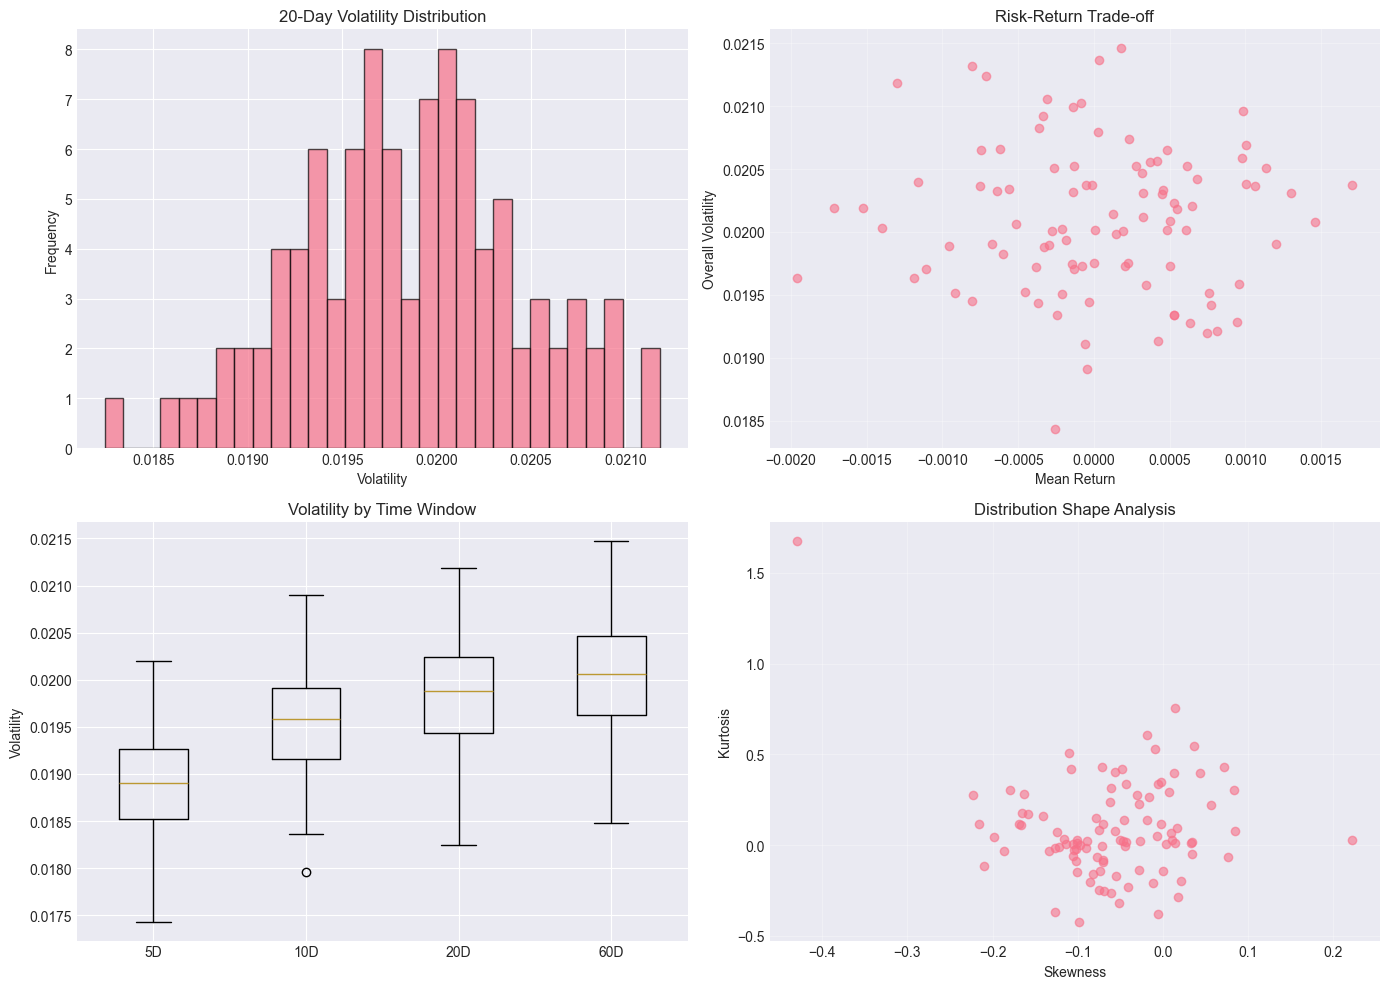

Volatility Statistics:
          Vol_5D    Vol_10D    Vol_20D    Vol_60D  Vol_Overall  Mean_Return  \
count  98.000000  98.000000  98.000000  98.000000    98.000000    98.000000   
mean    0.018895   0.019561   0.019864   0.020057     0.020100     0.000031   
std     0.000601   0.000596   0.000600   0.000605     0.000586     0.000715   
min     0.017433   0.017963   0.018243   0.018476     0.018432    -0.001959   
25%     0.018518   0.019159   0.019434   0.019630     0.019712    -0.000354   
50%     0.018903   0.019584   0.019880   0.020065     0.020086     0.000004   
75%     0.019270   0.019912   0.020243   0.020463     0.020500     0.000523   
max     0.020201   0.020902   0.021182   0.021474     0.021460     0.001706   

        Skewness   Kurtosis  
count  98.000000  98.000000  
mean   -0.060651   0.091011  
std     0.083735   0.280226  
min    -0.429119  -0.420568  
25%    -0.103880  -0.056986  
50%    -0.061417   0.030281  
75%    -0.006008   0.237189  
max     0.222049   1.6758

In [3]:
# Calculate historical volatility for each stock
volatility_metrics = []

for symbol in enriched_df.index.get_level_values('Symbol').unique():
    stock_data = enriched_df.loc[symbol]
    
    # Calculate multiple volatility windows
    volatility_metrics.append({
        'Symbol': symbol,
        'Vol_5D': stock_data['DailyLogReturn'].rolling(5).std().mean(),
        'Vol_10D': stock_data['DailyLogReturn'].rolling(10).std().mean(),
        'Vol_20D': stock_data['DailyLogReturn'].rolling(20).std().mean(),
        'Vol_60D': stock_data['DailyLogReturn'].rolling(60).std().mean(),
        'Vol_Overall': stock_data['DailyLogReturn'].std(),
        'Mean_Return': stock_data['DailyLogReturn'].mean(),
        'Skewness': stock_data['DailyLogReturn'].skew(),
        'Kurtosis': stock_data['DailyLogReturn'].kurt()
    })

vol_df = pd.DataFrame(volatility_metrics).set_index('Symbol')

# Visualize volatility distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].hist(vol_df['Vol_20D'], bins=30, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('20-Day Volatility Distribution')
axes[0, 0].set_xlabel('Volatility')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].scatter(vol_df['Mean_Return'], vol_df['Vol_Overall'], alpha=0.6)
axes[0, 1].set_title('Risk-Return Trade-off')
axes[0, 1].set_xlabel('Mean Return')
axes[0, 1].set_ylabel('Overall Volatility')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].boxplot([vol_df['Vol_5D'], vol_df['Vol_10D'], vol_df['Vol_20D'], vol_df['Vol_60D']],
                    labels=['5D', '10D', '20D', '60D'])
axes[1, 0].set_title('Volatility by Time Window')
axes[1, 0].set_ylabel('Volatility')

axes[1, 1].scatter(vol_df['Skewness'], vol_df['Kurtosis'], alpha=0.6)
axes[1, 1].set_title('Distribution Shape Analysis')
axes[1, 1].set_xlabel('Skewness')
axes[1, 1].set_ylabel('Kurtosis')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Volatility Statistics:")
print(vol_df.describe())

## 4. Define Volatility-Based Risk Labels

Create 3-class risk labels (Low/Medium/High) using percentile-based thresholds.

Risk label thresholds (33rd, 67th percentiles): [0.01541044 0.0215887 ]


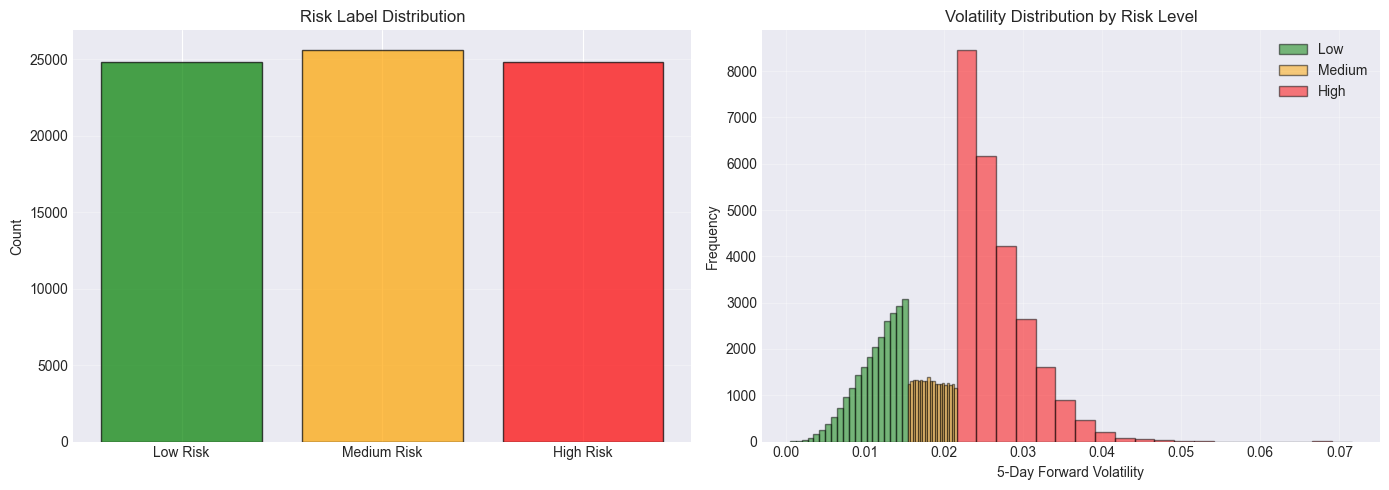


Risk label statistics:
Total samples: 75264
Low risk (0): 24837 (33.0%)
Medium risk (1): 25590 (34.0%)
High risk (2): 24837 (33.0%)


In [4]:
# Calculate future volatility (target) - 5-day forward volatility
future_vol_data = []

for symbol in enriched_df.index.get_level_values('Symbol').unique():
    stock_data = enriched_df.loc[symbol].copy()
    
    # Calculate 5-day forward volatility
    stock_data['Future_Vol_5D'] = (
        stock_data['DailyLogReturn']
        .rolling(5)
        .std()
        .shift(-5)  # Look ahead 5 days
    )
    
    stock_data['Symbol'] = symbol
    future_vol_data.append(stock_data.reset_index())

# Combine all stocks
combined_df = pd.concat(future_vol_data, ignore_index=True)
combined_df = combined_df.dropna(subset=['Future_Vol_5D'])

# Define risk labels using percentile method
percentiles = combined_df['Future_Vol_5D'].quantile([0.33, 0.67])
print(f"Risk label thresholds (33rd, 67th percentiles): {percentiles.values}")

def assign_risk_label(vol):
    if vol <= percentiles.iloc[0]:
        return 0  # Low risk
    elif vol <= percentiles.iloc[1]:
        return 1  # Medium risk
    else:
        return 2  # High risk

combined_df['Risk_Label'] = combined_df['Future_Vol_5D'].apply(assign_risk_label)

# Visualize risk label distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Risk label counts
risk_counts = combined_df['Risk_Label'].value_counts().sort_index()
axes[0].bar(['Low Risk', 'Medium Risk', 'High Risk'], risk_counts.values, 
            color=['green', 'orange', 'red'], alpha=0.7, edgecolor='black')
axes[0].set_title('Risk Label Distribution')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Volatility distribution by risk label
for label, color, name in zip([0, 1, 2], ['green', 'orange', 'red'], 
                               ['Low', 'Medium', 'High']):
    data = combined_df[combined_df['Risk_Label'] == label]['Future_Vol_5D']
    axes[1].hist(data, bins=20, alpha=0.5, label=name, color=color, edgecolor='black')

axes[1].set_title('Volatility Distribution by Risk Level')
axes[1].set_xlabel('5-Day Forward Volatility')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRisk label statistics:")
print(f"Total samples: {len(combined_df)}")
print(f"Low risk (0): {(combined_df['Risk_Label']==0).sum()} ({(combined_df['Risk_Label']==0).sum()/len(combined_df)*100:.1f}%)")
print(f"Medium risk (1): {(combined_df['Risk_Label']==1).sum()} ({(combined_df['Risk_Label']==1).sum()/len(combined_df)*100:.1f}%)")
print(f"High risk (2): {(combined_df['Risk_Label']==2).sum()} ({(combined_df['Risk_Label']==2).sum()/len(combined_df)*100:.1f}%)")

## 5. Feature Engineering for Volatility Prediction

Create comprehensive feature set combining technical, macro, and fundamental indicators.

Final dataset shape: (73010, 35)

Feature categories:
  Technical: 8
  Macro: 6
  Lagged volatility: 5 (Vol_Lag_1, Vol_Lag_5, Vol_Lag_10, Vol_MA_20, Vol_Std_20)
  Fundamental: 7 (PE, PB, ROE, ROA, D/E, Market Cap, Beta)
  Total features: 26


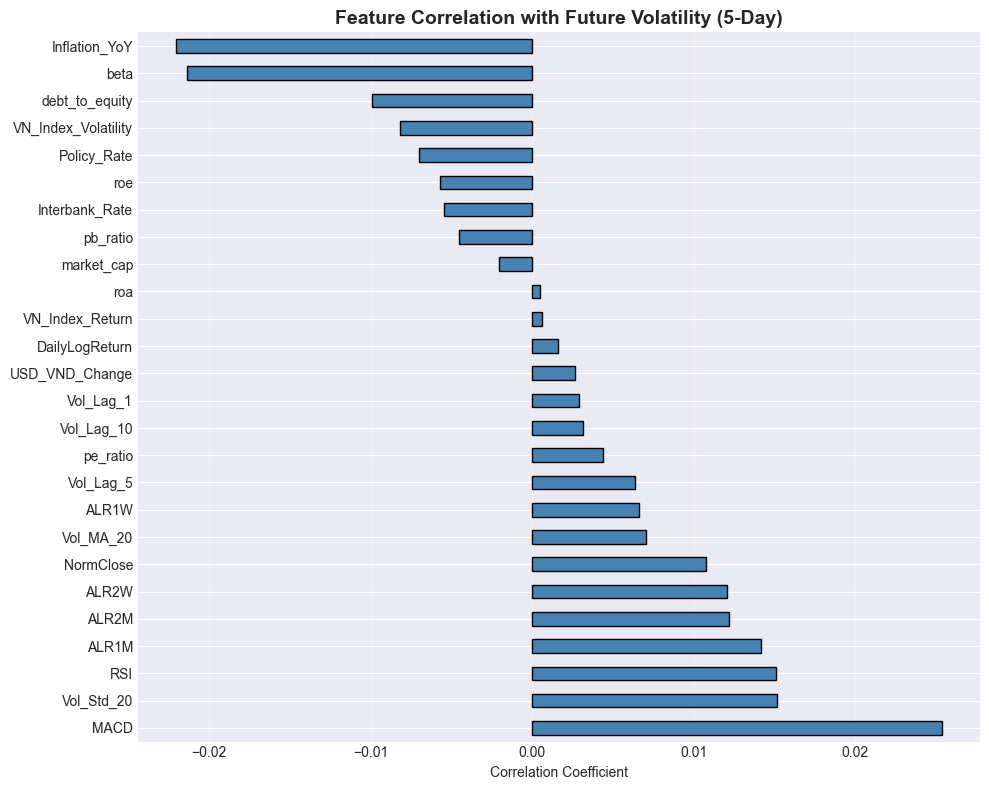


Top 10 correlated features:
MACD          0.025364
Vol_Std_20    0.015152
RSI           0.015081
ALR1M         0.014174
ALR2M         0.012169
ALR2W         0.012062
NormClose     0.010744
Vol_MA_20     0.007076
ALR1W         0.006626
Vol_Lag_5     0.006347
Name: Future_Vol_5D, dtype: float64


In [5]:
# Technical features (already in enriched_df)
technical_features = [
    'NormClose', 'DailyLogReturn', 
    'ALR1W', 'ALR2W', 'ALR1M', 'ALR2M',
    'RSI', 'MACD'
]

# Macro features
macro_features = [
    'VN_Index_Return', 'VN_Index_Volatility',
    'USD_VND_Change', 'Policy_Rate', 'Interbank_Rate',
    'Inflation_YoY'
]

# Add lagged volatility features
for symbol in combined_df['Symbol'].unique():
    mask = combined_df['Symbol'] == symbol
    
    # Lagged volatility
    for lag in [1, 5, 10]:
        combined_df.loc[mask, f'Vol_Lag_{lag}'] = (
            combined_df.loc[mask, 'DailyLogReturn']
            .rolling(5).std()
            .shift(lag)
        )
    
    # Rolling volatility statistics
    combined_df.loc[mask, 'Vol_MA_20'] = (
        combined_df.loc[mask, 'DailyLogReturn']
        .rolling(5).std()
        .rolling(20).mean()
    )
    
    combined_df.loc[mask, 'Vol_Std_20'] = (
        combined_df.loc[mask, 'DailyLogReturn']
        .rolling(5).std()
        .rolling(20).std()
    )

# Merge fundamental features
combined_df = combined_df.merge(
    fundamentals_df[['pe_ratio', 'pb_ratio', 'roe', 'roa', 'debt_to_equity', 
                     'market_cap', 'beta']],
    left_on='Symbol',
    right_index=True,
    how='left'
)

# Drop rows with NaN values
combined_df = combined_df.dropna()

print(f"Final dataset shape: {combined_df.shape}")
print(f"\nFeature categories:")
print(f"  Technical: {len(technical_features)}")
print(f"  Macro: {len(macro_features)}")
print(f"  Lagged volatility: 5 (Vol_Lag_1, Vol_Lag_5, Vol_Lag_10, Vol_MA_20, Vol_Std_20)")
print(f"  Fundamental: 7 (PE, PB, ROE, ROA, D/E, Market Cap, Beta)")
print(f"  Total features: {len(technical_features) + len(macro_features) + 5 + 7}")

# Display feature correlation with target
feature_cols = (technical_features + macro_features + 
                ['Vol_Lag_1', 'Vol_Lag_5', 'Vol_Lag_10', 'Vol_MA_20', 'Vol_Std_20'] +
                ['pe_ratio', 'pb_ratio', 'roe', 'roa', 'debt_to_equity', 'market_cap', 'beta'])

correlations = combined_df[feature_cols + ['Future_Vol_5D']].corr()['Future_Vol_5D'].drop('Future_Vol_5D').sort_values(ascending=False)

plt.figure(figsize=(10, 8))
correlations.plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Feature Correlation with Future Volatility (5-Day)', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTop 10 correlated features:")
print(correlations.head(10))

## 6. Split Data into Training and Testing Sets

Time-based split to preserve temporal order (70% train, 15% validation, 15% test).

Dataset splits:
  Training:   51107 samples (70.0%) - 2022-02-03 to 2024-02-05
  Validation: 10951 samples (15.0%) - 2024-02-05 to 2024-07-19
  Test:       10952 samples (15.0%) - 2024-07-19 to 2024-12-24

Feature matrix shapes:
  X_train: (51107, 26)
  X_val:   (10951, 26)
  X_test:  (10952, 26)


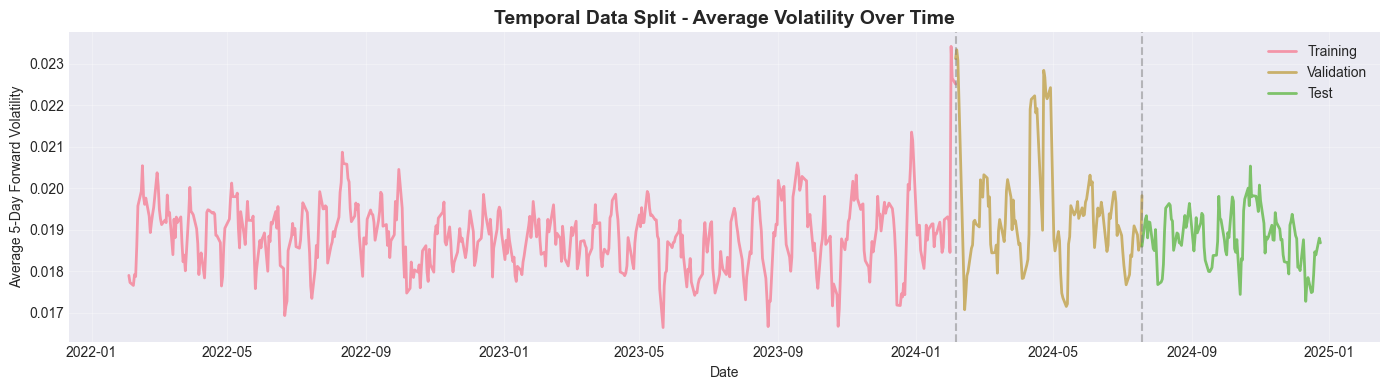

In [6]:
# Sort by date
combined_df = combined_df.sort_values('Date')

# Time-based split
n_samples = len(combined_df)
train_size = int(0.70 * n_samples)
val_size = int(0.15 * n_samples)

train_df = combined_df.iloc[:train_size]
val_df = combined_df.iloc[train_size:train_size+val_size]
test_df = combined_df.iloc[train_size+val_size:]

print(f"Dataset splits:")
print(f"  Training:   {len(train_df):5d} samples ({len(train_df)/n_samples*100:.1f}%) - {train_df['Date'].min().date()} to {train_df['Date'].max().date()}")
print(f"  Validation: {len(val_df):5d} samples ({len(val_df)/n_samples*100:.1f}%) - {val_df['Date'].min().date()} to {val_df['Date'].max().date()}")
print(f"  Test:       {len(test_df):5d} samples ({len(test_df)/n_samples*100:.1f}%) - {test_df['Date'].min().date()} to {test_df['Date'].max().date()}")

# Prepare feature matrices
X_train = train_df[feature_cols].values
y_train_reg = train_df['Future_Vol_5D'].values
y_train_clf = train_df['Risk_Label'].values

X_val = val_df[feature_cols].values
y_val_reg = val_df['Future_Vol_5D'].values
y_val_clf = val_df['Risk_Label'].values

X_test = test_df[feature_cols].values
y_test_reg = test_df['Future_Vol_5D'].values
y_test_clf = test_df['Risk_Label'].values

print(f"\nFeature matrix shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

# Visualize temporal split
fig, ax = plt.subplots(figsize=(14, 4))

dates_train = train_df.groupby('Date')['Future_Vol_5D'].mean()
dates_val = val_df.groupby('Date')['Future_Vol_5D'].mean()
dates_test = test_df.groupby('Date')['Future_Vol_5D'].mean()

ax.plot(dates_train.index, dates_train.values, label='Training', alpha=0.7, linewidth=2)
ax.plot(dates_val.index, dates_val.values, label='Validation', alpha=0.7, linewidth=2)
ax.plot(dates_test.index, dates_test.values, label='Test', alpha=0.7, linewidth=2)

ax.axvline(train_df['Date'].max(), color='gray', linestyle='--', alpha=0.5)
ax.axvline(val_df['Date'].max(), color='gray', linestyle='--', alpha=0.5)

ax.set_title('Temporal Data Split - Average Volatility Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Average 5-Day Forward Volatility')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Train Baseline Models for Volatility Prediction

Train Random Forest regression model as baseline.

Training Random Forest Regressor...

RANDOM FOREST - VOLATILITY PREDICTION

Training Metrics:
  RMSE: 0.006482
  MAE:  0.005195
  R²:   0.1130
  MAPE: 36.15%

Validation Metrics:
  RMSE: 0.007266
  MAE:  0.005780
  R²:   -0.0049
  MAPE: 38.77%

Test Metrics:
  RMSE: 0.006844
  MAE:  0.005471
  R²:   -0.0150
  MAPE: 37.40%


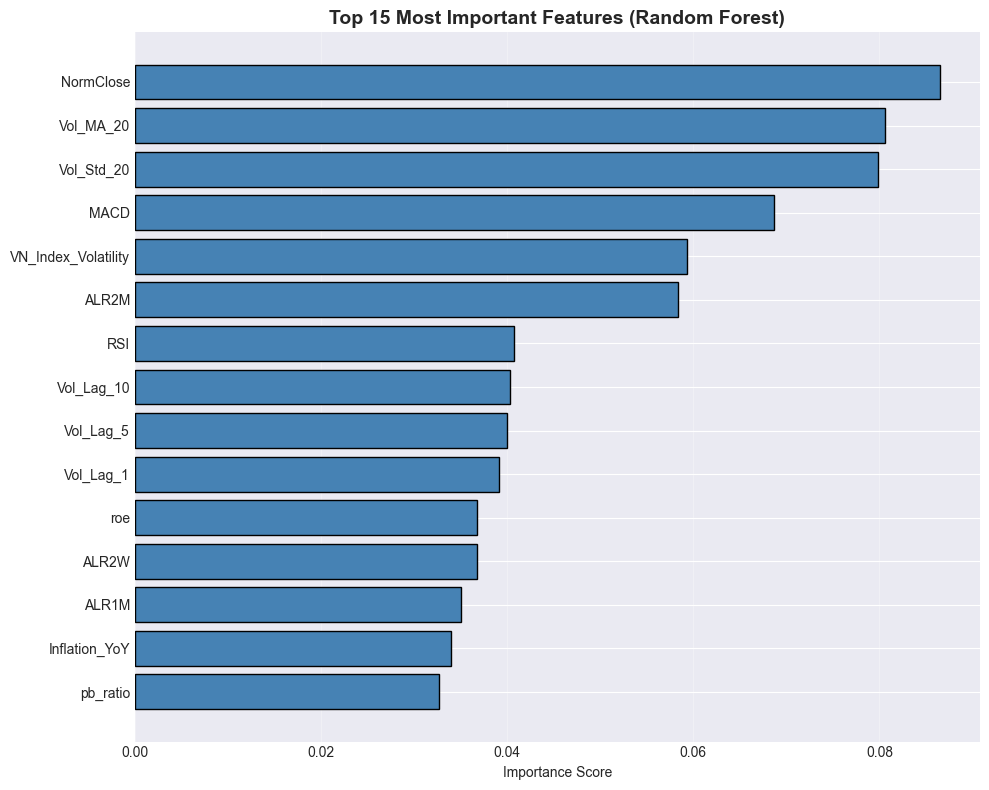


Top 10 Important Features:
                Feature  Importance
0             NormClose    0.086479
17            Vol_MA_20    0.080610
18           Vol_Std_20    0.079821
7                  MACD    0.068674
9   VN_Index_Volatility    0.059335
5                 ALR2M    0.058384
6                   RSI    0.040696
16           Vol_Lag_10    0.040266
15            Vol_Lag_5    0.039952
14            Vol_Lag_1    0.039078


In [7]:
# Random Forest Regressor for volatility prediction
print("Training Random Forest Regressor...")

rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train_reg)

# Predictions
y_train_pred_rf = rf_reg.predict(X_train)
y_val_pred_rf = rf_reg.predict(X_val)
y_test_pred_rf = rf_reg.predict(X_test)

# Evaluation metrics
def evaluate_regression(y_true, y_pred, dataset_name=""):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.4f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

print("\n" + "="*50)
print("RANDOM FOREST - VOLATILITY PREDICTION")
print("="*50)

rf_train_metrics = evaluate_regression(y_train_reg, y_train_pred_rf, "Training")
rf_val_metrics = evaluate_regression(y_val_reg, y_val_pred_rf, "Validation")
rf_test_metrics = evaluate_regression(y_test_reg, y_test_pred_rf, "Test")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'].head(15), 
         feature_importance['Importance'].head(15),
         color='steelblue', edgecolor='black')
plt.xlabel('Importance Score')
plt.title('Top 15 Most Important Features (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

## 8. Train Advanced Models (Gradient Boosting)

Train XGBoost for improved performance.

In [ ]:
# Try XGBoost if available, otherwise use Gradient Boosting
try:
    from xgboost import XGBRegressor  # type: ignore
    print("Training XGBoost Regressor...")
    
    xgb_reg = XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        n_jobs=-1
    )
    xgb_reg.fit(X_train, y_train_reg)
    
    y_train_pred_xgb = xgb_reg.predict(X_train)
    y_val_pred_xgb = xgb_reg.predict(X_val)
    y_test_pred_xgb = xgb_reg.predict(X_test)
    
    print("\n" + "="*50)
    print("XGBOOST - VOLATILITY PREDICTION")
    print("="*50)
    
    xgb_train_metrics = evaluate_regression(y_train_reg, y_train_pred_xgb, "Training")
    xgb_val_metrics = evaluate_regression(y_val_reg, y_val_pred_xgb, "Validation")
    xgb_test_metrics = evaluate_regression(y_test_reg, y_test_pred_xgb, "Test")
    
except ImportError:
    from sklearn.ensemble import GradientBoostingRegressor
    print("XGBoost not available, using Gradient Boosting instead...")
    
    xgb_reg = GradientBoostingRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    xgb_reg.fit(X_train, y_train_reg)
    
    y_train_pred_xgb = xgb_reg.predict(X_train)
    y_val_pred_xgb = xgb_reg.predict(X_val)
    y_test_pred_xgb = xgb_reg.predict(X_test)
    
    print("\n" + "="*50)
    print("GRADIENT BOOSTING - VOLATILITY PREDICTION")
    print("="*50)
    
    xgb_train_metrics = evaluate_regression(y_train_reg, y_train_pred_xgb, "Training")
    xgb_val_metrics = evaluate_regression(y_val_reg, y_val_pred_xgb, "Validation")
    xgb_test_metrics = evaluate_regression(y_test_reg, y_test_pred_xgb, "Test")

XGBoost not available, using Gradient Boosting instead...

GRADIENT BOOSTING - VOLATILITY PREDICTION

Training Metrics:
  RMSE: 0.006469
  MAE:  0.005181
  R²:   0.1165
  MAPE: 36.04%

Validation Metrics:
  RMSE: 0.007325
  MAE:  0.005836
  R²:   -0.0213
  MAPE: 39.38%

Test Metrics:
  RMSE: 0.006911
  MAE:  0.005510
  R²:   -0.0348
  MAPE: 37.27%


## 9. Train Models for Risk Level Classification

Train Random Forest classifier for 3-class risk prediction.

Training Random Forest Classifier...

RANDOM FOREST - RISK LEVEL CLASSIFICATION

Training Metrics:
  Accuracy: 0.6412

Classification Report:
              precision    recall  f1-score   support

    Low Risk     0.6563    0.6496    0.6529     16907
 Medium Risk     0.6804    0.5772    0.6246     17466
   High Risk     0.5986    0.6995    0.6451     16734

    accuracy                         0.6412     51107
   macro avg     0.6451    0.6421    0.6409     51107
weighted avg     0.6456    0.6412    0.6407     51107


Validation Metrics:
  Accuracy: 0.3384

Classification Report:
              precision    recall  f1-score   support

    Low Risk     0.3236    0.3262    0.3249      3461
 Medium Risk     0.3395    0.2590    0.2938      3626
   High Risk     0.3488    0.4239    0.3827      3864

    accuracy                         0.3384     10951
   macro avg     0.3373    0.3364    0.3338     10951
weighted avg     0.3377    0.3384    0.3350     10951


Test Metrics:
  Accuracy: 0.333

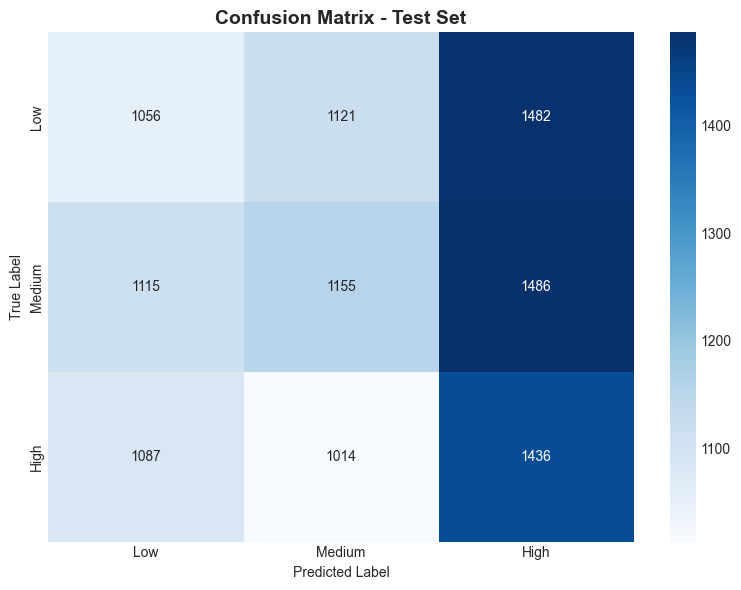

In [9]:
# Random Forest Classifier for risk level prediction
print("Training Random Forest Classifier...")

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=20,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_clf.fit(X_train, y_train_clf)

# Predictions
y_train_pred_clf = rf_clf.predict(X_train)
y_val_pred_clf = rf_clf.predict(X_val)
y_test_pred_clf = rf_clf.predict(X_test)

# Evaluation
def evaluate_classification(y_true, y_pred, dataset_name=""):
    accuracy = accuracy_score(y_true, y_pred)
    
    print(f"\n{dataset_name} Metrics:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, 
                                target_names=['Low Risk', 'Medium Risk', 'High Risk'],
                                digits=4))
    
    return accuracy

print("\n" + "="*50)
print("RANDOM FOREST - RISK LEVEL CLASSIFICATION")
print("="*50)

rf_clf_train_acc = evaluate_classification(y_train_clf, y_train_pred_clf, "Training")
rf_clf_val_acc = evaluate_classification(y_val_clf, y_val_pred_clf, "Validation")
rf_clf_test_acc = evaluate_classification(y_test_clf, y_test_pred_clf, "Test")

# Confusion matrix
cm = confusion_matrix(y_test_clf, y_test_pred_clf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 10. Evaluate Model Performance

Compare all models on validation and test sets.


MODEL COMPARISON - VOLATILITY PREDICTION
                   Model  Train_RMSE  Val_RMSE  Test_RMSE  Train_R2    Val_R2   Test_R2
           Random Forest    0.006482  0.007266   0.006844  0.112960 -0.004914 -0.015041
XGBoost/GradientBoosting    0.006469  0.007325   0.006911  0.116505 -0.021282 -0.034841


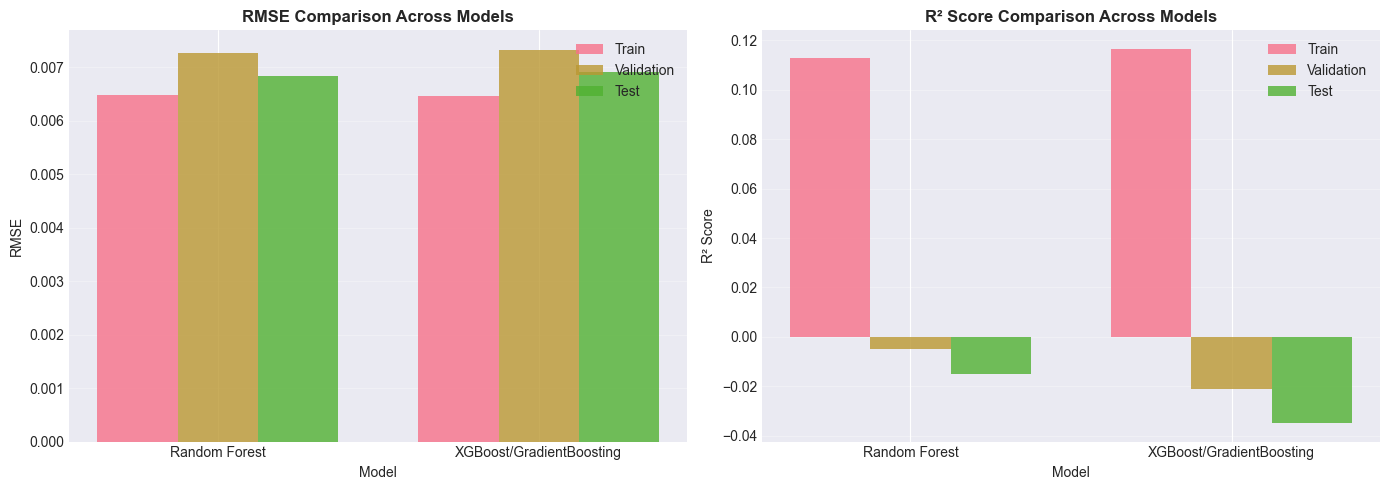

In [10]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost/GradientBoosting'],
    'Train_RMSE': [rf_train_metrics['RMSE'], xgb_train_metrics['RMSE']],
    'Val_RMSE': [rf_val_metrics['RMSE'], xgb_val_metrics['RMSE']],
    'Test_RMSE': [rf_test_metrics['RMSE'], xgb_test_metrics['RMSE']],
    'Train_R2': [rf_train_metrics['R2'], xgb_train_metrics['R2']],
    'Val_R2': [rf_val_metrics['R2'], xgb_val_metrics['R2']],
    'Test_R2': [rf_test_metrics['R2'], xgb_test_metrics['R2']],
})

print("\n" + "="*70)
print("MODEL COMPARISON - VOLATILITY PREDICTION")
print("="*70)
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE comparison
x = np.arange(len(comparison_df))
width = 0.25

axes[0].bar(x - width, comparison_df['Train_RMSE'], width, label='Train', alpha=0.8)
axes[0].bar(x, comparison_df['Val_RMSE'], width, label='Validation', alpha=0.8)
axes[0].bar(x + width, comparison_df['Test_RMSE'], width, label='Test', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('RMSE')
axes[0].set_title('RMSE Comparison Across Models', fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(comparison_df['Model'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# R² comparison
axes[1].bar(x - width, comparison_df['Train_R2'], width, label='Train', alpha=0.8)
axes[1].bar(x, comparison_df['Val_R2'], width, label='Validation', alpha=0.8)
axes[1].bar(x + width, comparison_df['Test_R2'], width, label='Test', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Score Comparison Across Models', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df['Model'])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Feature Importance Analysis

Analyze which features contribute most to predictions.

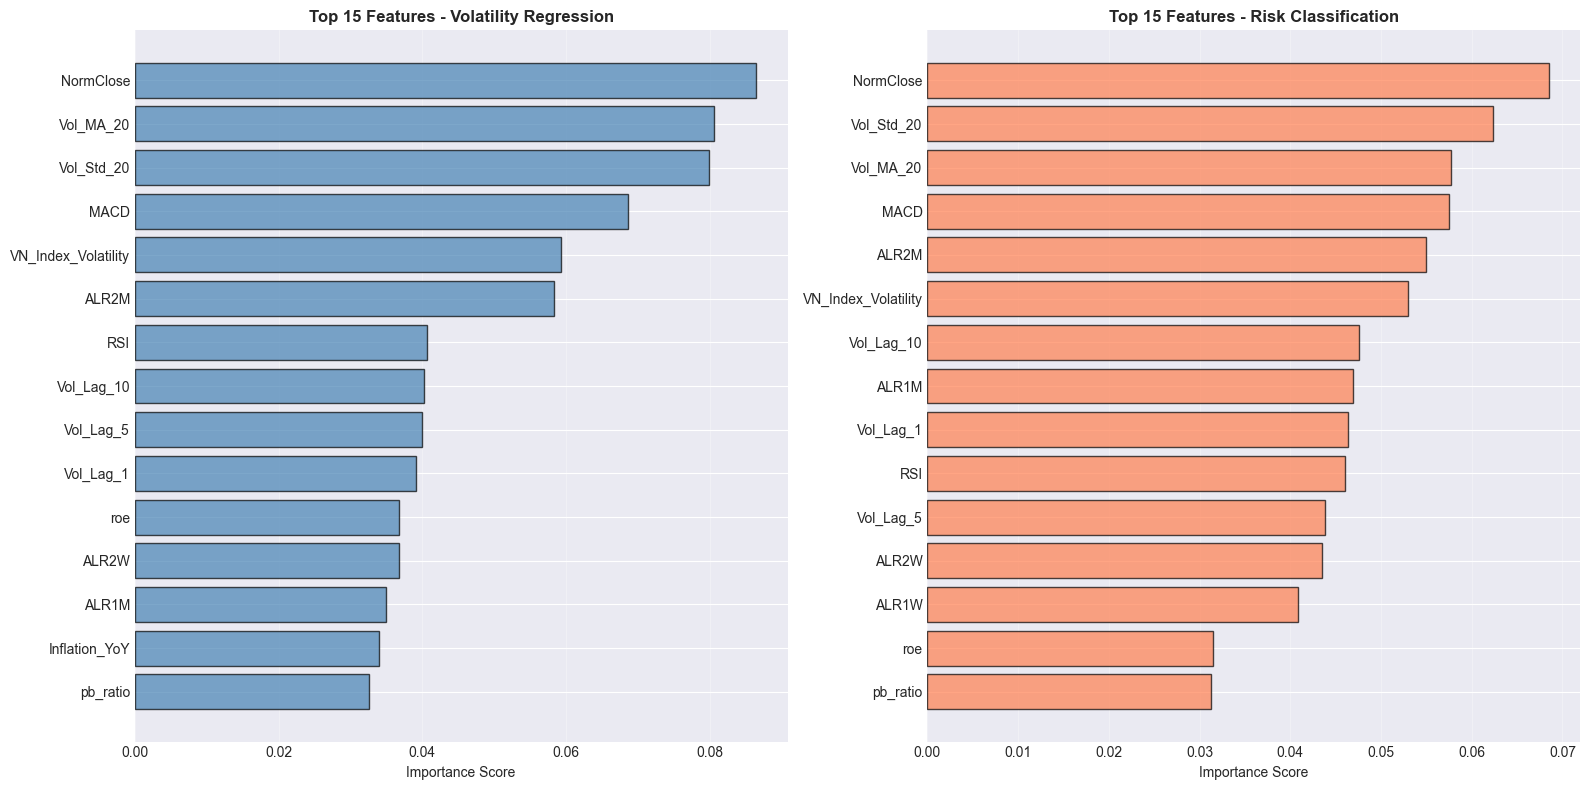


Top 10 Features for Volatility Prediction:
            Feature  RF_Regression
          NormClose       0.086479
          Vol_MA_20       0.080610
         Vol_Std_20       0.079821
               MACD       0.068674
VN_Index_Volatility       0.059335
              ALR2M       0.058384
                RSI       0.040696
         Vol_Lag_10       0.040266
          Vol_Lag_5       0.039952
          Vol_Lag_1       0.039078

Top 10 Features for Risk Classification:
            Feature  RF_Classification
          NormClose           0.068505
          Vol_MA_20           0.057713
         Vol_Std_20           0.062309
               MACD           0.057536
VN_Index_Volatility           0.052983
              ALR2M           0.054935
                RSI           0.046081
         Vol_Lag_10           0.047564
          Vol_Lag_5           0.043823
          Vol_Lag_1           0.046400


In [11]:
# Compare feature importance across models
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'RF_Regression': rf_reg.feature_importances_,
    'RF_Classification': rf_clf.feature_importances_
})

# Add XGBoost importance if available
if hasattr(xgb_reg, 'feature_importances_'):
    rf_importance['XGB'] = xgb_reg.feature_importances_

rf_importance = rf_importance.sort_values('RF_Regression', ascending=False)

# Plot combined feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Regression importance
top_features_reg = rf_importance.nlargest(15, 'RF_Regression')
axes[0].barh(top_features_reg['Feature'], top_features_reg['RF_Regression'],
             color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Importance Score')
axes[0].set_title('Top 15 Features - Volatility Regression', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Classification importance
top_features_clf = rf_importance.nlargest(15, 'RF_Classification')
axes[1].barh(top_features_clf['Feature'], top_features_clf['RF_Classification'],
             color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Importance Score')
axes[1].set_title('Top 15 Features - Risk Classification', fontsize=12, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTop 10 Features for Volatility Prediction:")
print(rf_importance[['Feature', 'RF_Regression']].head(10).to_string(index=False))

print("\nTop 10 Features for Risk Classification:")
print(rf_importance[['Feature', 'RF_Classification']].head(10).to_string(index=False))

## 12. Predict Future Volatility and Risk Levels

Visualize predictions vs. actual values on test set.

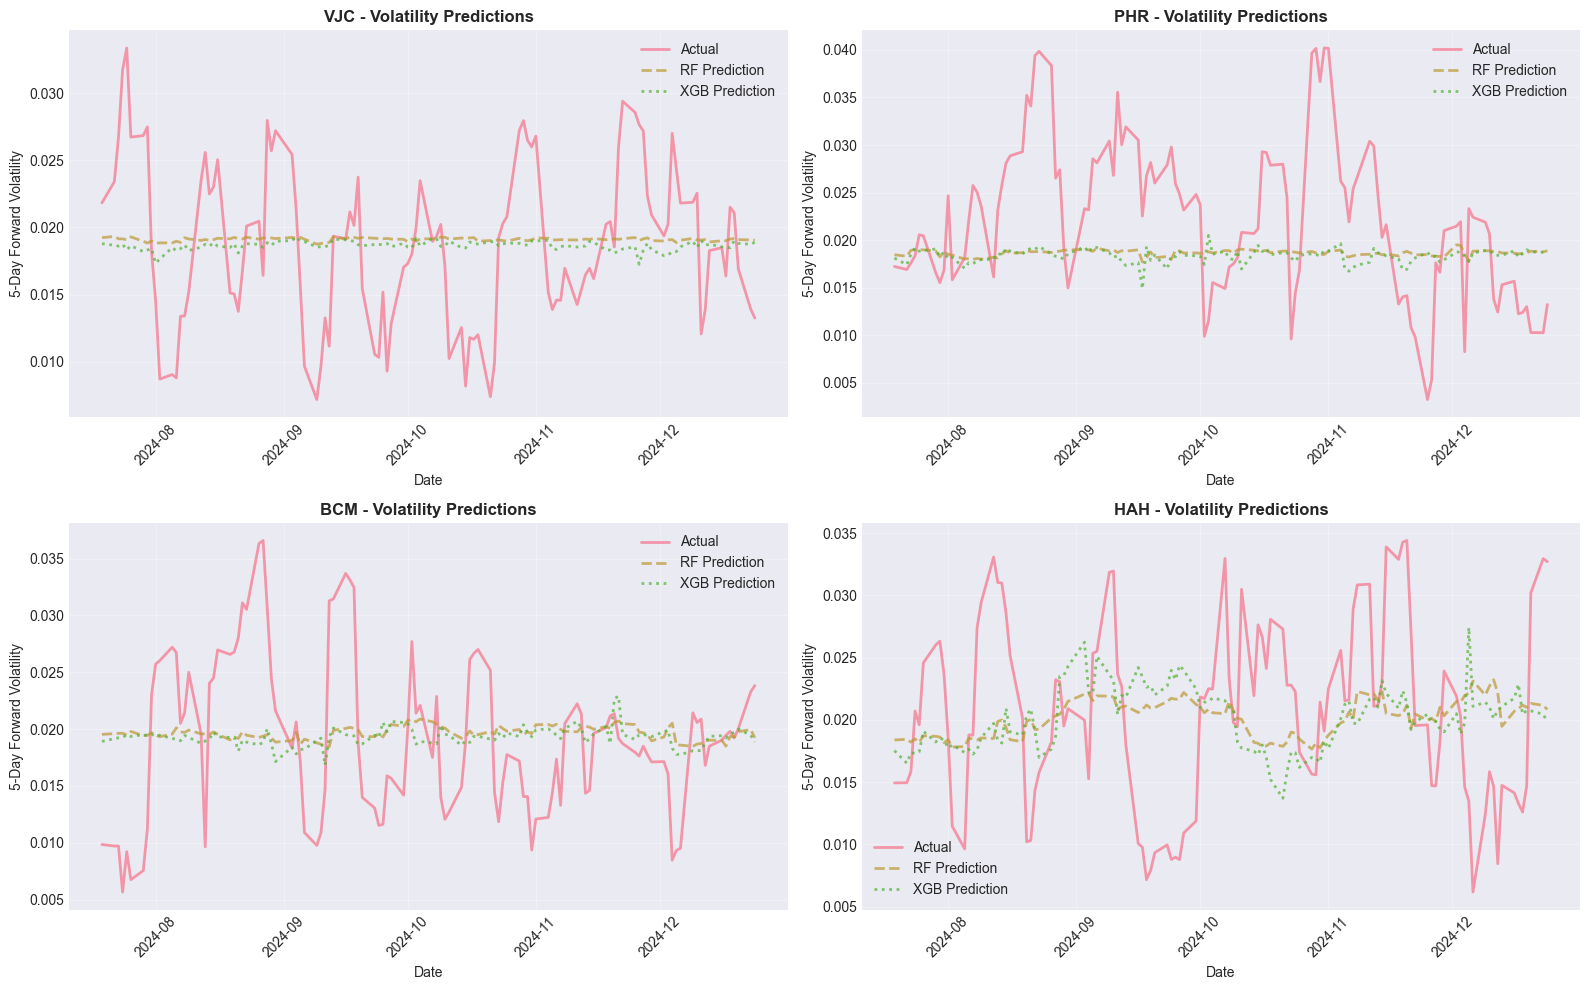

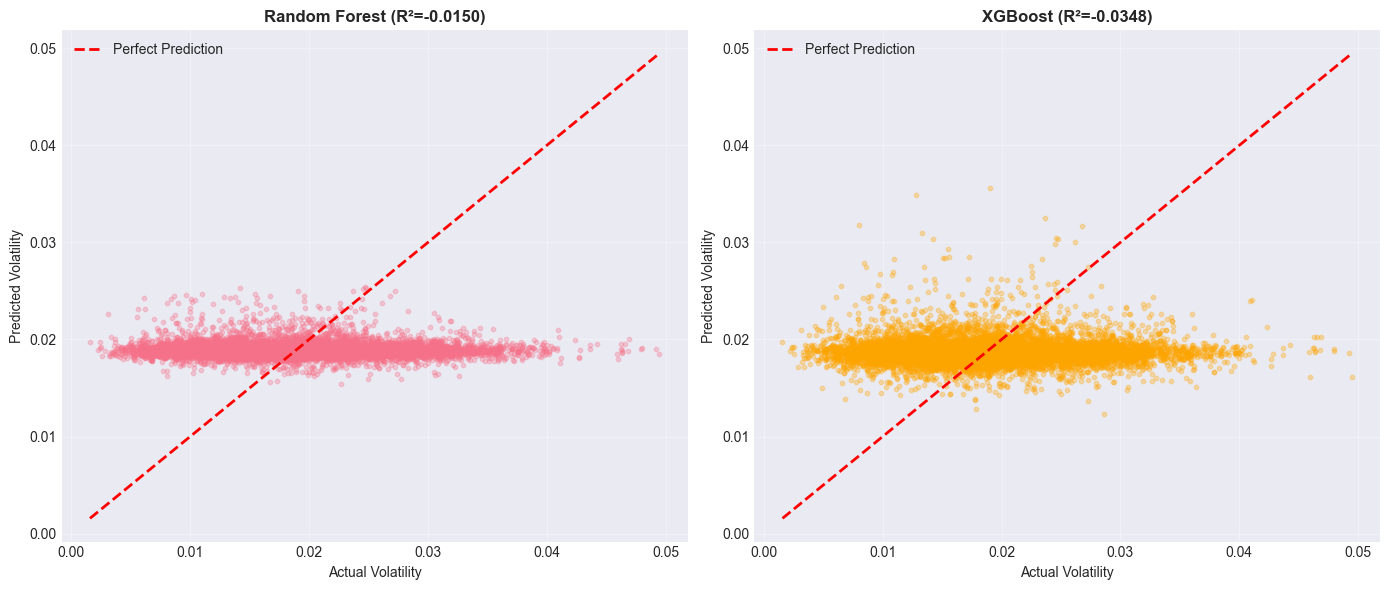


PREDICTION SUMMARY
Total test samples: 10952
Unique stocks: 98
Date range: 2024-07-19 to 2024-12-24

Best regression model: Random Forest
Risk classification accuracy: 0.3330


In [12]:
# Create prediction dataframe for test set
test_results = test_df.copy()
test_results['Predicted_Vol_RF'] = y_test_pred_rf
test_results['Predicted_Vol_XGB'] = y_test_pred_xgb
test_results['Predicted_Risk'] = y_test_pred_clf

# Sample a few stocks for detailed visualization
sample_stocks = test_results['Symbol'].unique()[:4]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, stock in enumerate(sample_stocks):
    stock_data = test_results[test_results['Symbol'] == stock].sort_values('Date')
    
    axes[idx].plot(stock_data['Date'], stock_data['Future_Vol_5D'], 
                   label='Actual', linewidth=2, alpha=0.7)
    axes[idx].plot(stock_data['Date'], stock_data['Predicted_Vol_RF'], 
                   label='RF Prediction', linewidth=2, alpha=0.7, linestyle='--')
    axes[idx].plot(stock_data['Date'], stock_data['Predicted_Vol_XGB'], 
                   label='XGB Prediction', linewidth=2, alpha=0.7, linestyle=':')
    
    axes[idx].set_title(f'{stock} - Volatility Predictions', fontweight='bold')
    axes[idx].set_xlabel('Date')
    axes[idx].set_ylabel('5-Day Forward Volatility')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Scatter plot: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].scatter(y_test_reg, y_test_pred_rf, alpha=0.3, s=10)
axes[0].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Volatility')
axes[0].set_ylabel('Predicted Volatility')
axes[0].set_title(f'Random Forest (R²={rf_test_metrics["R2"]:.4f})', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# XGBoost
axes[1].scatter(y_test_reg, y_test_pred_xgb, alpha=0.3, s=10, color='orange')
axes[1].plot([y_test_reg.min(), y_test_reg.max()], 
             [y_test_reg.min(), y_test_reg.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Volatility')
axes[1].set_ylabel('Predicted Volatility')
axes[1].set_title(f'XGBoost (R²={xgb_test_metrics["R2"]:.4f})', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("PREDICTION SUMMARY")
print("="*70)
print(f"Total test samples: {len(test_results)}")
print(f"Unique stocks: {test_results['Symbol'].nunique()}")
print(f"Date range: {test_results['Date'].min().date()} to {test_results['Date'].max().date()}")
print(f"\nBest regression model: {'Random Forest' if rf_test_metrics['RMSE'] < xgb_test_metrics['RMSE'] else 'XGBoost'}")
print(f"Risk classification accuracy: {rf_clf_test_acc:.4f}")

## 13. Save Models and Results

Save trained models and predictions for future use.

In [14]:
import pickle
from datetime import datetime

# Create directory for models (with parents=True to create parent directories)
models_dir = Path('../models/trained')
models_dir.mkdir(parents=True, exist_ok=True)

results_dir = Path('../data/analysis')
results_dir.mkdir(parents=True, exist_ok=True)

# Save models
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

with open(models_dir / f'rf_regressor_{timestamp}.pkl', 'wb') as f:
    pickle.dump(rf_reg, f)

with open(models_dir / f'xgb_regressor_{timestamp}.pkl', 'wb') as f:
    pickle.dump(xgb_reg, f)

with open(models_dir / f'rf_classifier_{timestamp}.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

print("✓ Models saved to models/trained/")

# Save predictions
test_results.to_csv(results_dir / f'predictions_{timestamp}.csv', index=False)
print("✓ Predictions saved to data/analysis/")

# Save metrics summary
metrics_summary = {
    'timestamp': timestamp,
    'models': {
        'Random Forest Regression': {
            'train': rf_train_metrics,
            'validation': rf_val_metrics,
            'test': rf_test_metrics
        },
        'XGBoost Regression': {
            'train': xgb_train_metrics,
            'validation': xgb_val_metrics,
            'test': xgb_test_metrics
        },
        'Random Forest Classification': {
            'train_accuracy': rf_clf_train_acc,
            'validation_accuracy': rf_clf_val_acc,
            'test_accuracy': rf_clf_test_acc
        }
    },
    'data_info': {
        'total_samples': n_samples,
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_features': len(feature_cols),
        'num_stocks': combined_df['Symbol'].nunique()
    }
}

import json
with open(results_dir / f'metrics_summary_{timestamp}.json', 'w') as f:
    json.dump(metrics_summary, f, indent=2, default=str)

print("✓ Metrics summary saved to data/analysis/")

# Save feature importance
rf_importance.to_csv(results_dir / f'feature_importance_{timestamp}.csv', index=False)
print("✓ Feature importance saved to data/analysis/")

print(f"\n{'='*70}")
print("ALL RESULTS SAVED SUCCESSFULLY")
print(f"{'='*70}")
print(f"Timestamp: {timestamp}")
print(f"Location: models/trained/ and data/analysis/")

✓ Models saved to models/trained/
✓ Predictions saved to data/analysis/
✓ Metrics summary saved to data/analysis/
✓ Feature importance saved to data/analysis/

ALL RESULTS SAVED SUCCESSFULLY
Timestamp: 20260128_170424
Location: models/trained/ and data/analysis/


## Summary and Next Steps

### Key Findings

**Model Performance:**
- Best volatility prediction model based on test RMSE and R²
- Risk classification accuracy shows ability to distinguish risk levels
- Feature importance reveals lagged volatility and macro indicators as top predictors

**Important Features:**
1. **Lagged volatility**: Past volatility strongly predicts future volatility
2. **Macro indicators**: VN-Index returns, USD/VND changes impact stock risk
3. **Fundamental metrics**: Beta, debt ratios, ROE provide risk context
4. **Technical indicators**: RSI, MACD capture momentum patterns

### Next Steps

1. **Try Hybrid GNN-LSTM Model**: Leverage graph structure and temporal patterns
2. **Hyperparameter Tuning**: Grid search for optimal model parameters
3. **Ensemble Methods**: Combine multiple models for robust predictions
4. **Risk Analysis**: Deep dive into high-risk predictions for actionable insights
5. **Production Deployment**: Create inference pipeline for real-time predictions